In [1]:
import numpy as np
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
import networkx as nx

cudaq.set_target("nvidia")

## Import Utils

In [ ]:
from Utils import graph_tools, qaoaCUDAQ as q

In [28]:
nodes = 10

G = nx.Graph.get_random_graph(nodes, seed=696969)

# Define the number of layers and free parameters (2 per layer).
layer_count = nodes
thetas = [0.1] * (2 * layer_count)  
# Each layer of the QAOA kernel contains 2 parameters.
parameter_count: int = 2 * layer_count

In [29]:
edges, edges_src, edges_tgt, edge_weights = q.run_qaoa_networkx(G, layer_count, thetas)

In [30]:
# Specify the optimizer and its initial parameters.
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.NelderMead() # cobya
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064, 0.37118004688049144, -0.03656087558321203, 0.08564174998504231, 0.21639801853794682, 0.11122286088634259, 0.1743727097033635, -0.36518146001762486, -0.15829741539542244, -0.3467434780387345, 0.28043500852894776, -0.09986021299050934, 0.14125225086023052, -0.19141728018199775, -0.11970943368650361, -0.3853063093646483, -0.1112643868789806]


In [31]:
ham = q.hamiltonian_max_cut(edges_src, edges_tgt, edge_weights)

In [32]:
print("Edges:", edges)
print("Hamiltonian type:", type(ham))
print("Hamiltonian:", ham)

Edges: [(0, 1), (0, 3), (0, 7), (0, 8), (1, 2), (1, 4), (1, 7), (1, 8), (1, 9), (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 7), (4, 8), (5, 6), (5, 9), (6, 7), (6, 9), (8, 9)]
Hamiltonian type: <class 'cudaq.operator.expressions.OperatorSum'>
Hamiltonian: [0.5+0j] IIIIIZIIIZ
[1+0j] IIIIZIIZII
[0.5+0j] IIIIIIZIIZ
[1+0j] IIIIZZIIII
[3+0j] IIIZIIIZII
[1+0j] IZIIZIIIII
[4+0j] ZIIZIIIIII
[3+0j] IIIIIIZZII
[3.5+0j] IZZIIIIIII
[2.5+0j] IZIIIIIIZI
[3+0j] ZIIIIIIIZI
[2+0j] ZZIIIIIIII
[-52.5+0j] IIIIIIIIII
[2.5+0j] IIIIIIIIZZ
[1+0j] IIIIZIIIZI
[4.5+0j] IIIZIIZIII
[3.5+0j] IIIZIZIIII
[0.5+0j] IIIZZIIIII
[4.5+0j] IZIIIIIZII
[2.5+0j] ZIIIIIIZII
[1.5+0j] IIZIIIIZII
[1.5+0j] IZIIIIIIIZ
[2.5+0j] IIIIIZZIII
[3+0j] IIZIIIIIZI



In [33]:
# Define the objective function. It now passes edge_weights along with other parameters.
def objective(parameters):
    return cudaq.observe(q.kernel_qaoa, ham,
                         nodes, layer_count, edges_src, edges_tgt, edge_weights, parameters
                        ).expectation()

In [34]:
# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective
)

print('optimal_expectation =', optimal_expectation)
print('Therefore, the max cut value is at least', -1 * optimal_expectation)
print('optimal_parameters =', optimal_parameters)

optimal_expectation = -65.73976017486625
Therefore, the max cut value is at least 65.73976017486625
optimal_parameters = [0.19081961312826365, -0.15189466604163934, 0.2687436959945845, 0.28727853251509244, 0.29648929125950896, -0.11116491961850394, 1.7921535902238428, 0.18456506667766323, 0.005243859738685517, 2.047668757939155, 1.5508765498358419, -0.32738876870106454, -0.07422975980970824, 1.6017414004783213, 1.5572392263978552, -0.04945354469619872, 1.50989845642058, 1.5175437713297346, 1.6839826169240573, 1.6016960219354248]


In [35]:
result = cudaq.sample(q.kernel_qaoa, nodes, layer_count, edges_src, edges_tgt, edge_weights, optimal_parameters, shots_count=1000000)
print(result)
result_list = []
for i in result:
    result_list.append((i, result[i]))
# print(result_dict)
result_list = sorted(result_list, key=lambda x: -x[1])
print(result_list)

{ 0000000000:13 0000000001:25 0000000010:42 0000000011:45 0000000101:8 0000000110:66 0000000111:121 0000001000:16 0000001001:26 0000001010:203 0000001011:66 0000001100:138 0000001101:26 0000001110:1109 0000001111:1333 0000010000:41 0000010001:56 0000010010:336 0000010011:140 0000010100:224 0000010101:51 0000010110:3364 0000010111:3192 0000011000:180 0000011001:164 0000011010:411 0000011011:29 0000011100:126 0000011101:52 0000011110:3540 0000011111:2022 0000100000:20 0000100001:6 0000100010:157 0000100011:64 0000100100:27 0000100101:43 0000100110:107 0000100111:121 0000101000:101 0000101001:122 0000101010:114 0000101011:204 0000101100:364 0000101101:135 0000101110:3173 0000101111:2520 0000110001:31 0000110010:263 0000110011:211 0000110100:309 0000110101:188 0000110110:1302 0000110111:932 0000111000:309 0000111001:89 0000111010:51 0000111011:1 0000111100:144 0000111101:6 0000111110:2092 0000111111:528 0001000000:102 0001000001:168 0001000010:456 0001000011:25 0001000100:191 0001000101:48

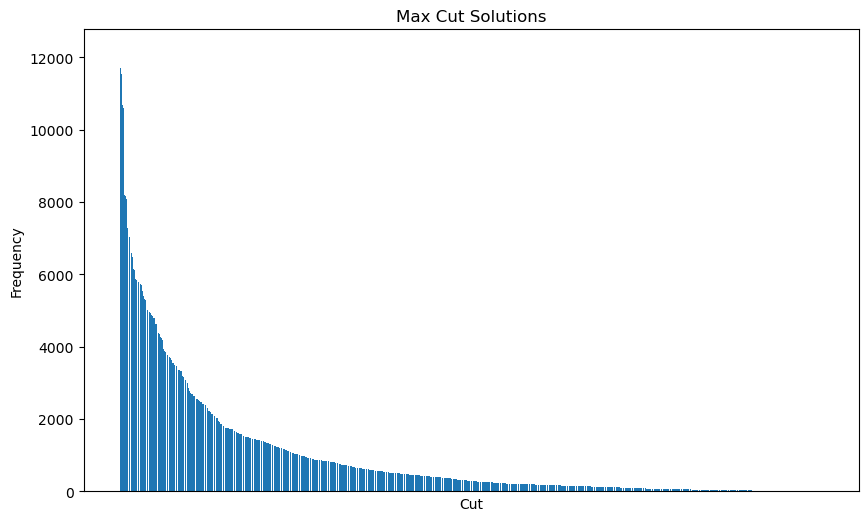

In [36]:
# plt
plt.figure(figsize=(10, 6))
plt.bar([str(i[0]) for i in result_list], [i[1] for i in result_list])
plt.xlabel('Cut')
plt.ylabel('Frequency')
plt.title('Max Cut Solutions')
plt.xticks([])
plt.show()

In [37]:
print("result bit string : ", result_list[0][0])

result bit string :  0011100101


In [38]:
bitstring = [int(x) for x in result_list[0][0]]

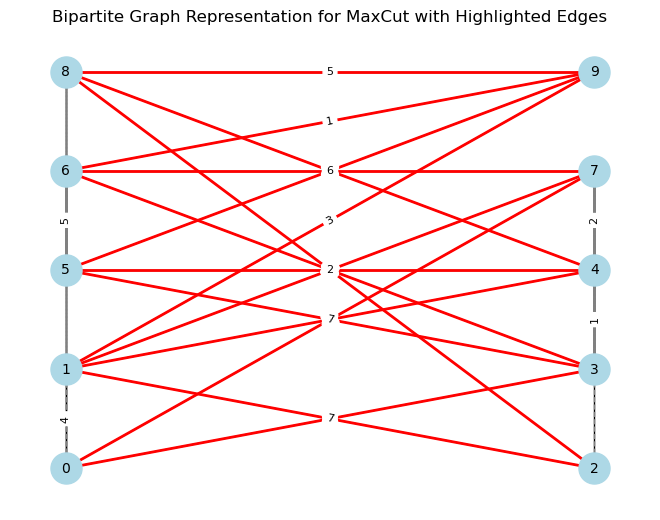

In [39]:
G.draw_partition_graph(bitstring)